# Do something to look at sub-species level variation in samples

One of the strengths of metagenome sequencing is that it captures strain-level variation in microbial communities.
However, even for relatively simple communities, it's difficult to visualize all of the strains that are present in a given community or all communities at once.
This notebook attempts to create a set of parsing rules to identify and visualize strains of interest in sets of related metagenomes (e.g. metagenomes that come from the gut microbiome). 
The set of metagenomes used here are from a time series (one sample from each of six time points).
I've tried to write this notebook to enable the visualize identification of "interesting" patterns in strain differences between samples. 

### Definition of a strain

For the purposes of this notebook, we refer to a strain as any sub-species level variation. 
This notebook uses a genome as a strain definition -- each genome is considered a different strain.
If you identify interesting patterns using the analysis in this notebook, you'll need to dig into them further to confirm the trends seen here.

### Important caveats for interpretation of strain plots

Sourmash `gather` compares a query (here, a metagenome) against a database (GenBank microbial genomes) and provides the minimum set of genomes the cover all of the k-mers in the query that are in the database. 
At least two things can be happening when sourmash `gather` returns two genomes of the same species (e.g. different strains) as a match to the same metagenome sample:
1. Both strains may be present in the metagenome
2. Only one strain may be truly present in the metagenome, but that strain is not contained within our current reference database. Instead, _pieces_ of that strain's genome are in _other_ genomes in the database. The genome in the database that contains the largest overlap with the genome in the metagenome is returned first as the best match. Then, other genomes in the database are returned that match other portions of the metagenome strain's genome that wasn't contained in the best match.

In reality, some combination of these two things probably happens.
This means that a few things for interpretation of strain-level results from sourmash `gather`:
1. We can't detect strain variation if there is only one genome for a given species in the database using sourmash `gather`/`taxonomy` alone (variant calling tools or tools that look at variation in assembly graphs would be more successful for this use case).
2. We can't interpret the sourmash `gather`/`taxonomy` results alone to conclusively detect strain variation, but it is a good place to start to figure out where to dig in deeper. 

However, from staring at A LOT of sourmash `gather` results over the years, and digging into them more using other tools, I have noticed a general rule of thumb to guess whether real strain variation is occurring -- if two strains are detected in the same sample, and both have a high unique fraction of shared base pairs with the metagenome, and both have a high percentage of their genome detected in the metagenome, that is usually a pretty good indicator that real strain variation is occurring. However, this should absolutley always be confirmed still using other tools.

In [1]:
setwd("..")

In [80]:
# adjust plot size rendered inline
options(repr.plot.width = 15, repr.plot.height = 15, repr.plot.res = 300)

In [44]:
library(readr)
library(dplyr)
library(tidyr)
library(purrr)
library(tibble)
library(ggplot2)
library(plotly)

## Read in and parse sourmash `taxonomy` results

In [54]:
# read in the sourmash taxonomy results from all samples into a single data frame
sourmash_taxonomy_results <- Sys.glob("outputs/sourmash_taxonomy/*genbank-2022.03-k31.with-lineages.csv") %>%
  map_dfr(read_csv, col_types = "ddddddddcccddddcccdc") %>% # read in all of the taxonomy results
  mutate(name = gsub(" .*", "", name)) %>%  # simplify the genome name to only include the accession
  separate(lineage, into = c("domain", "phylum", "class", "order", "family", "genus", "species", "strain"), sep = ";", remove = F) %>% # separate out taxonomic levels
  mutate(lowest_taxonomic_assignment = ifelse(!is.na(strain), strain, species), # make a label for plots
         lineage_species = paste(domain, phylum, class, order, family, genus, species, sep = ";")) # make a lineage that doesn't include strain

Warning message:
“Expected 8 pieces. Missing pieces filled with `NA` in 4999 rows [1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, ...].”


## identify species that potentially have sub-species level variation  (e.g. multiple strains detected for one species)

This section experiments with different filtering criteria that might be useful for zero-ing in on "interesting" strain variable patterns without any other apriori knowledge of the samples (including statistical testing that could robustly identify these patterns). 

The goal is to find some code that will help zero in on species that have strain variation that we might care about.

Not every code block in the following section is used in this notebook, but I left them all in because they might be useful for other data sets in the future.

In [69]:
# determine how many genomes are observed for each species in each sample
# NOT USED FOR PLOTS
genomes_per_species_per_sample <- sourmash_taxonomy_results %>%
  select(query_name, lineage_species, name) %>%
  distinct() %>%
  group_by(query_name, lineage_species) %>%
  tally() %>%
  filter(n >= 2) %>%
  arrange(lineage_species)

nrow(genomes_per_species_per_sample)
head(genomes_per_species_per_sample)

[1] 366

query_name,lineage_species,n
<chr>,<chr>,<int>
SRR19888440,Bacteria;Acidobacteria;unassigned;unassigned;unassigned;unassigned;Acidobacteria bacterium,2
SRR19888427,Bacteria;Actinobacteria;Acidimicrobiia;Acidimicrobiales;unassigned;unassigned;Acidimicrobiales bacterium,2
SRR19888427,Bacteria;Actinobacteria;Actinomycetia;Actinomycetales;unassigned;unassigned;Actinomycetales bacterium,3
SRR19888423,Bacteria;Actinobacteria;Actinomycetia;Corynebacteriales;Corynebacteriaceae;Corynebacterium;Corynebacterium casei,5
SRR19888427,Bacteria;Actinobacteria;Actinomycetia;Corynebacteriales;Corynebacteriaceae;Corynebacterium;Corynebacterium casei,5
SRR19888432,Bacteria;Actinobacteria;Actinomycetia;Corynebacteriales;Corynebacteriaceae;Corynebacterium;Corynebacterium casei,5


In [66]:
# grab species that are observed in more than one sample
# NOT USED FOR PLOTS
species_observed_in_more_than_one_sample <- sourmash_taxonomy_results %>%
  select(query_name, lineage_species, name) %>%
  distinct() %>%
  group_by(query_name, lineage_species) %>%
  tally() %>%
  ungroup() %>%
  group_by(lineage_species) %>%
  tally() %>%
  filter(n > 1)

nrow(species_observed_in_more_than_one_sample)
head(species_observed_in_more_than_one_sample)

[1] 946

lineage_species,n
<chr>,<int>
Archaea;Candidatus Micrarchaeota;unassigned;unassigned;unassigned;unassigned;Candidatus Micrarchaeota archaeon,2
Bacteria;Acidobacteria;Holophagae;Holophagales;Holophagaceae;unassigned;Holophagaceae bacterium UBA706,2
Bacteria;Acidobacteria;unassigned;unassigned;unassigned;unassigned;Acidobacteria bacterium,6
Bacteria;Actinobacteria;Acidimicrobiia;Acidimicrobiales;Acidimicrobiaceae;unassigned;Acidimicrobiaceae bacterium,2
Bacteria;Actinobacteria;Acidimicrobiia;Acidimicrobiales;unassigned;unassigned;Acidimicrobiales bacterium,4
Bacteria;Actinobacteria;Actinomycetia;Actinomycetales;Actinomycetaceae;Actinomyces;Actinomyces sp.,5


In [90]:
# grab species that have at least two different genomes that each take up at least 1% of at least one sample
# USED FOR PLOTS
species_with_two_abundant_genomes <- sourmash_taxonomy_results %>%
  filter(f_unique_weighted >= 0.01) %>% # decrease this number to visualize more species
  group_by(lineage_species) %>%
  tally() %>%
  filter(n > 1) %>%
  arrange(desc(n))

nrow(species_with_two_abundant_genomes)
head(species_with_two_abundant_genomes)

[1] 15

lineage_species,n
<chr>,<int>
Bacteria;Actinobacteria;Actinomycetia;Micrococcales;Brevibacteriaceae;Brevibacterium;Brevibacterium aurantiacum,11
Bacteria;Actinobacteria;Actinomycetia;Corynebacteriales;Corynebacteriaceae;Corynebacterium;Candidatus Corynebacterium faecigallinarum,6
Bacteria;Actinobacteria;Actinomycetia;Corynebacteriales;Corynebacteriaceae;Corynebacterium;Corynebacterium casei,6
Bacteria;Actinobacteria;Actinomycetia;Micrococcales;Brevibacteriaceae;Brevibacterium;Brevibacterium sp. S111,3
Bacteria;Actinobacteria;Actinomycetia;Micrococcales;Microbacteriaceae;Agrococcus;Agrococcus casei,3
Bacteria;Bacteroidetes;Flavobacteriia;Flavobacteriales;Flavobacteriaceae;Psychroflexus;Psychroflexus sp. S27,3


## Plot strains

Most of the plots below are shown as interactive plots. 
If you'd prefer a static plot, run the object that is defined by the ggplot lines of code.

### Plot strain composition for a user-defined set of genomes

Plot strain composition of samples based on a user-defined species of interest.
Below we demonstrate this plot with _Corynebacterium casei_.

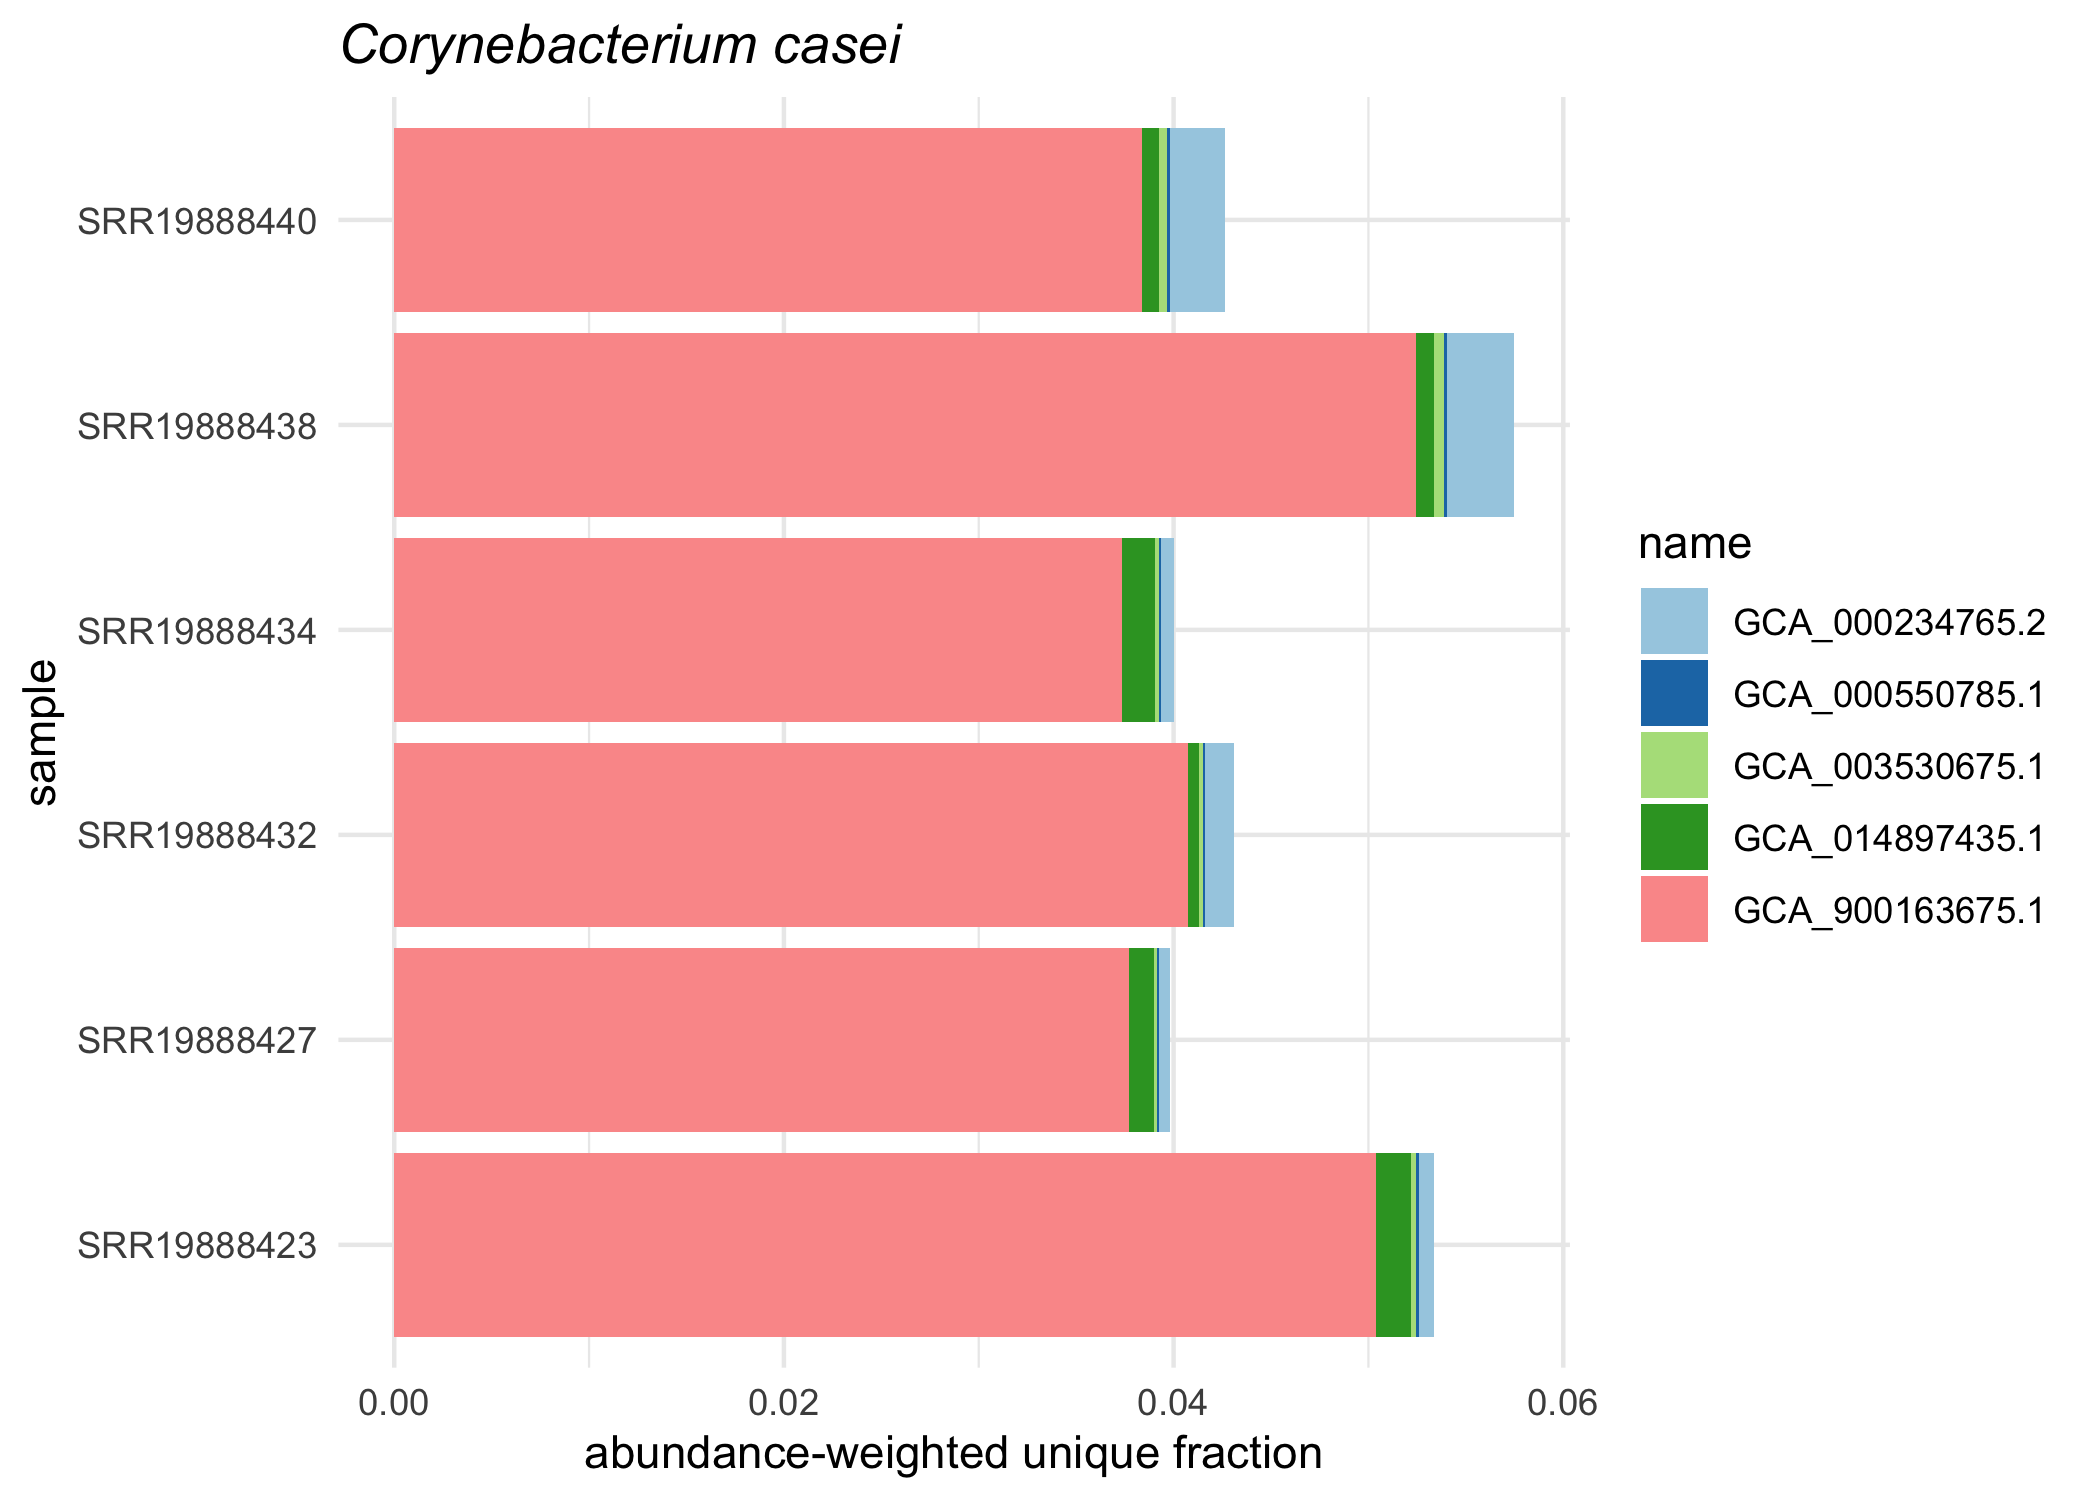

In [93]:
options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 300)

sourmash_taxonomy_results_one <- sourmash_taxonomy_results %>% 
  filter(species == "Corynebacterium casei")

p <- ggplot(sourmash_taxonomy_results_one, aes(x = query_name, y = f_unique_weighted, 
                                                    fill = name, label = lowest_taxonomic_assignment)) +
  geom_col() +
  theme_minimal() +
  theme(plot.title = element_text(face = "italic")) +
  coord_flip() +
  labs(title = unique(sourmash_taxonomy_results_one$species),
       x = "sample",
       y = "abundance-weighted unique fraction") +
  scale_fill_brewer(palette = "Paired")

p

In [ ]:
# run this code block to make an interactive plot and render it inline in jupyter notebook
# note the visualization won't render on github
pp <- ggplotly(p)
embed_notebook(pp)

### Plot all of the strains from our filtering above

The color palette here is atrocious, but leaving it as is means that it will scale ~infinitely as more genomes are added. 
Since each facet will have a combination of genomes, and most won't be alphabetically similar to other genomes included on the plot, I'm hoping that this palette preserves enough contrast to pick out potentially interesting strain variability through visualization alone.
The static plot is less useful than the interactive plot (see the `ggplotly()` command), however only the static plot will render on github, so I've included it below.
The interactive plot is nice because it details the name of the genome and the lowest taxonomic classification (e.g. species or strain) for the genome when you hover over a colored segment.

In the example below, we see that for this time series, most strains are consistently the same over time. The two exceptions are _Brachybacterium alimentarium_ and _Brevibacterium aurantiacum_. 

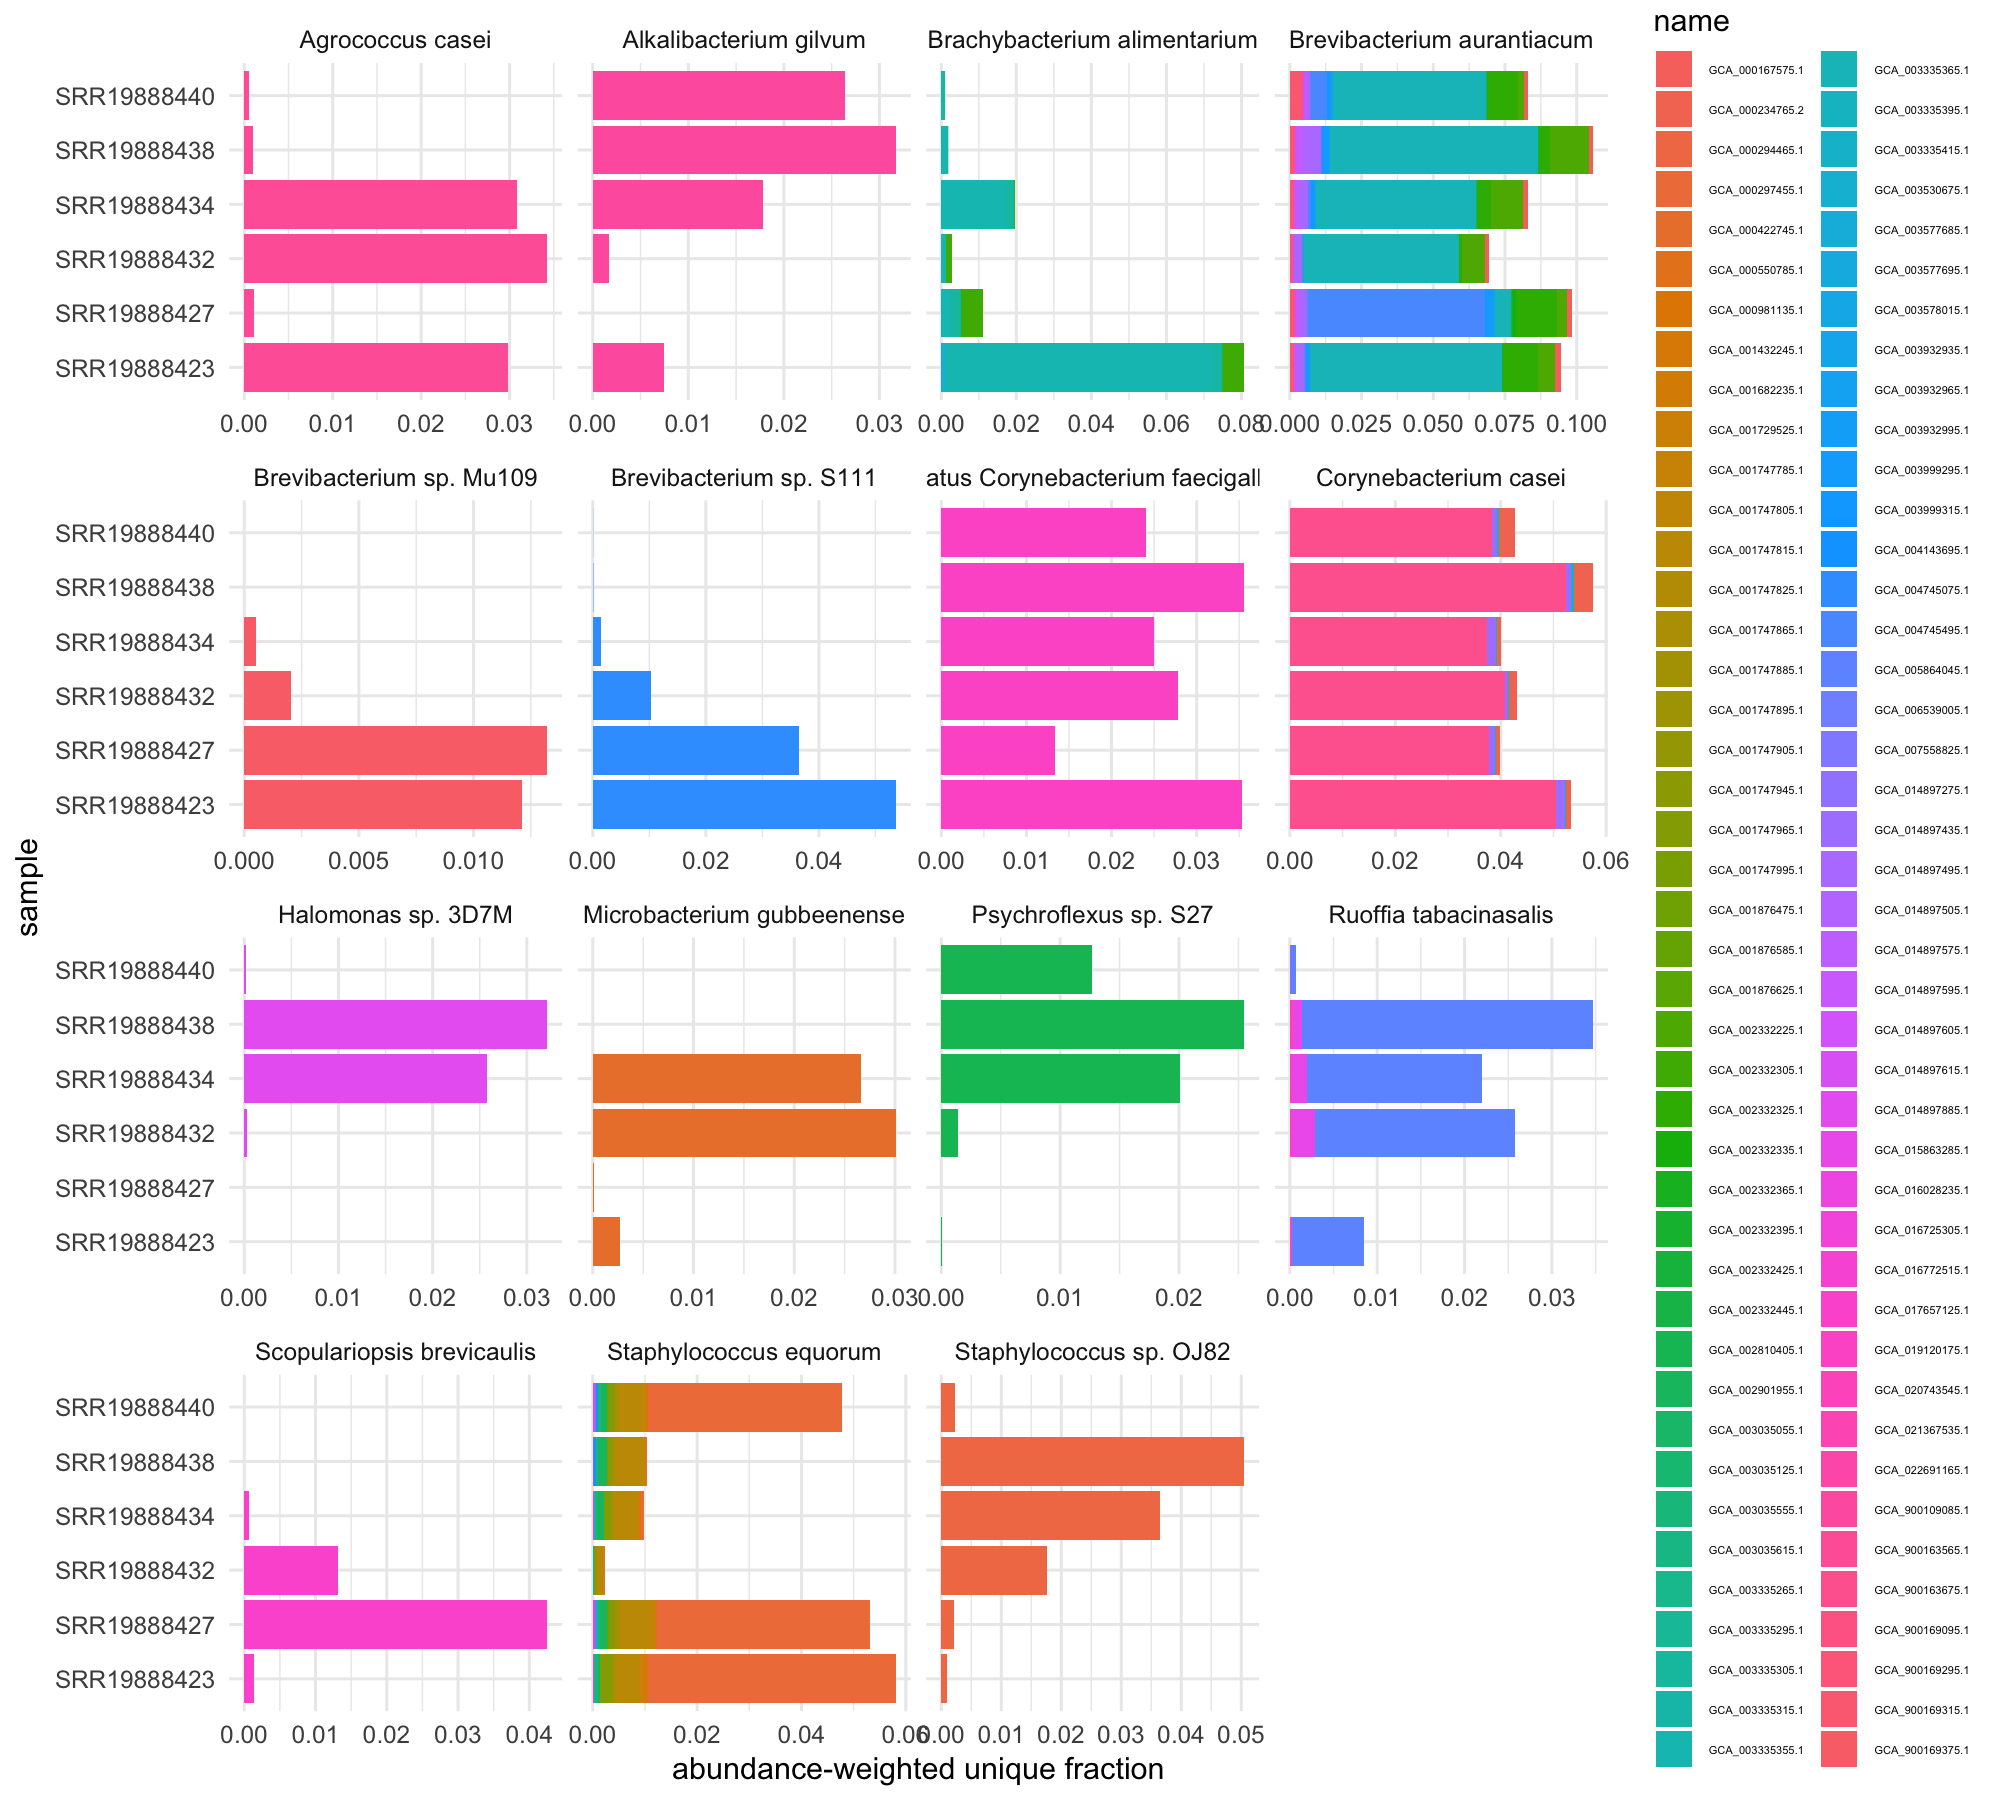

In [110]:
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 200)

sourmash_taxonomy_results_filtered <- sourmash_taxonomy_results %>%
  filter(lineage_species %in% species_with_two_abundant_genomes$lineage_species)

p <- ggplot(sourmash_taxonomy_results_filtered, aes(x = query_name, y = f_unique_weighted, 
                                               fill = name, label = lowest_taxonomic_assignment)) +
  geom_col() +
  theme_minimal() +
  theme(plot.title = element_text(face = "italic"),
        legend.text = element_text(size = 4),
        legend.key.size = unit(1,"line")) +
  coord_flip() +
  facet_wrap(~ species, scales = "free_x") +
  guides(fill=guide_legend(ncol=2)) +
  labs(x = "sample",
       y = "abundance-weighted unique fraction")

p

In [ ]:
# run this code block to make an interactive plot and render it inline in jupyter notebook
# note the visualization won't render on github
pp <- ggplotly(p)
embed_notebook(pp, width = 1100, height = "800px")
htmlwidgets::saveWidget(pp, "strain.html") # write the plotly html to a file